# Final Project
## CSCE 633
## Arya Rahmanian
## Summer 2024

### Load Dataset

In [78]:
import pandas as pd

splits = {'train': 'yelp_review_full/train-00000-of-00001.parquet', 'test': 'yelp_review_full/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])

In [79]:
# get train and test df
train_df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["test"])

# randomly select data points and split data into train, test, and valid
train_data = train_df.sample(n=10000, random_state=42)
val_data = train_df.drop(train_data.index).sample(n=1000, random_state=42)
test_data = test_df.sample(n=2000, random_state=42)

print("Training Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())

Training Data:
        label                                               text
177288      0  First of all i'm not a big fan of buffet, i tr...
238756      1  Thanks Yelp. I was looking for the words to de...
604225      2  Service was so-so. They were receiving a deliv...
2838        2  Stamoolis Brothers is one of the Strip Distric...
586957      0  I want to give a 2 stars because the service s...

Test Data:
       label                                               text
33553      4  Came a few days ago for a lease, wasn't sure o...
9427       0  I chose the 4 Queens for my visit to Las Vegas...
199        3  I went here on the day of a wedding (I'm from ...
12447      1  Isn't it strange how the little things can sou...
39489      4  Visit here several times a year. The food is a...


In [80]:
import requests
import os
"""
def download_glove_file(url, save_path='glove.twitter.27B.200d.txt'):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)
    return save_path
glove_url = "https://huggingface.co/spaces/grs2001/Helloglove/resolve/85085196f7dbe75aa83901aebbfc3b9c4ab4aae4/glove.twitter.27B.200d.txt"

# Download the GloVe embeddings
glove_file = download_glove_file(glove_url)
"""

'\ndef download_glove_file(url, save_path=\'glove.twitter.27B.200d.txt\'):\n    response = requests.get(url)\n    with open(save_path, \'wb\') as file:\n        file.write(response.content)\n    return save_path\nglove_url = "https://huggingface.co/spaces/grs2001/Helloglove/resolve/85085196f7dbe75aa83901aebbfc3b9c4ab4aae4/glove.twitter.27B.200d.txt"\n\n# Download the GloVe embeddings\nglove_file = download_glove_file(glove_url)\n'

In [81]:
import numpy as np

def load_glove_embeddings(file_path):
    embedding_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict


glove_file = 'glove.twitter.27B.200d.txt'

embedding_dict = load_glove_embeddings(glove_file)

### Data Pre-Processing

In [82]:
def map_labels(stars):
    return 0 if stars < 3 else 1

# create our label column
train_data['label'] = train_data['label'].apply(map_labels)
test_data['label'] = test_data['label'].apply(map_labels)
val_data['label'] = val_data['label'].apply(map_labels)


In [83]:
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

#function to preprocess text
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_data['text'] = train_data['text'].apply(preprocess_text)
val_data['text'] = val_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to C:\Users\Arya
[nltk_data]     Rahmanian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenize and Pad Text Vectors

In [84]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

train_sequences = tokenizer.texts_to_sequences(train_data['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# max length for sequences
max_length = 200

pad_last_words = True
if(pad_last_words):
    # Pad the last n characters
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='pre')
    val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='pre')
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='pre')
else:
    # Pad the first n characters
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
    val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# shape of padded sequences
print(train_padded.shape)
print(val_padded.shape)
print(test_padded.shape)

(10000, 200)
(1000, 200)
(2000, 200)


In [85]:
import torch
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 200  # GloVe dimension
embedding_matrix = np.zeros((vocab_size, embed_dim))

for word, index in tokenizer.word_index.items():
    if index >= vocab_size:
        continue
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Convert embedding matrix to tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


### Build Model

#### Model Architecture

In [86]:
import torch.nn as nn

class TransformerSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length, embedding_matrix):
        super(TransformerSentimentClassifier, self).__init__()
        
        # embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        # positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_dim))
        
        # transformer encoder layers
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        #self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)  # (batch_size, max_length, embed_dim)
        x += self.positional_encoding[:, :x.size(1), :]
        
        x = x.permute(1, 0, 2) 
        x = self.transformer_encoder(x)  # (max_length, batch_size, embed_dim)
        
        x = x.mean(dim=0)  # (batch_size, embed_dim)
        x = self.fc(x)  # (batch_size, num_classes)
        return x


#### Hyper-params

In [100]:
import torch.nn.functional as F

embed_dim = 200
num_heads = 8
hidden_dim = 512
num_layers = 4
num_classes = 2 
#vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token

# init model
model = TransformerSentimentClassifier(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length, embedding_matrix)

#### Build Dataloaders

In [101]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
BATCH_SIZE = 32

# convert to Torch tensors
X_train = torch.tensor(train_padded, dtype=torch.long)
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)
X_val = torch.tensor(val_padded, dtype=torch.long)
y_val = torch.tensor(val_data['label'].values, dtype=torch.long)
X_test = torch.tensor(test_padded, dtype=torch.long)
y_test = torch.tensor(test_data['label'].values, dtype=torch.long)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training

In [102]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW, Adam, SGD
from sklearn.model_selection import train_test_split

# lists to store training metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# constants hyper params
EPOCHS = 6
LEARNING_RATE = 0.0001

# init optimizer, and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_accuracy = 0.0
best_model_state_dict = None

#### Training Loop

In [103]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # validation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state_dict = model.state_dict()

Epoch 1/6, Loss: 0.3873, Accuracy: 0.8197
Validation Loss: 0.7242, Validation Accuracy: 0.7710
Epoch 2/6, Loss: 0.1570, Accuracy: 0.9377
Validation Loss: 0.7077, Validation Accuracy: 0.7890
Epoch 3/6, Loss: 0.1073, Accuracy: 0.9558
Validation Loss: 0.7442, Validation Accuracy: 0.7960
Epoch 4/6, Loss: 0.0882, Accuracy: 0.9646
Validation Loss: 0.8616, Validation Accuracy: 0.7870
Epoch 5/6, Loss: 0.0737, Accuracy: 0.9716
Validation Loss: 0.8101, Validation Accuracy: 0.7510
Epoch 6/6, Loss: 0.0604, Accuracy: 0.9772
Validation Loss: 1.0283, Validation Accuracy: 0.7910


In [91]:
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

### Plot Training Metrics

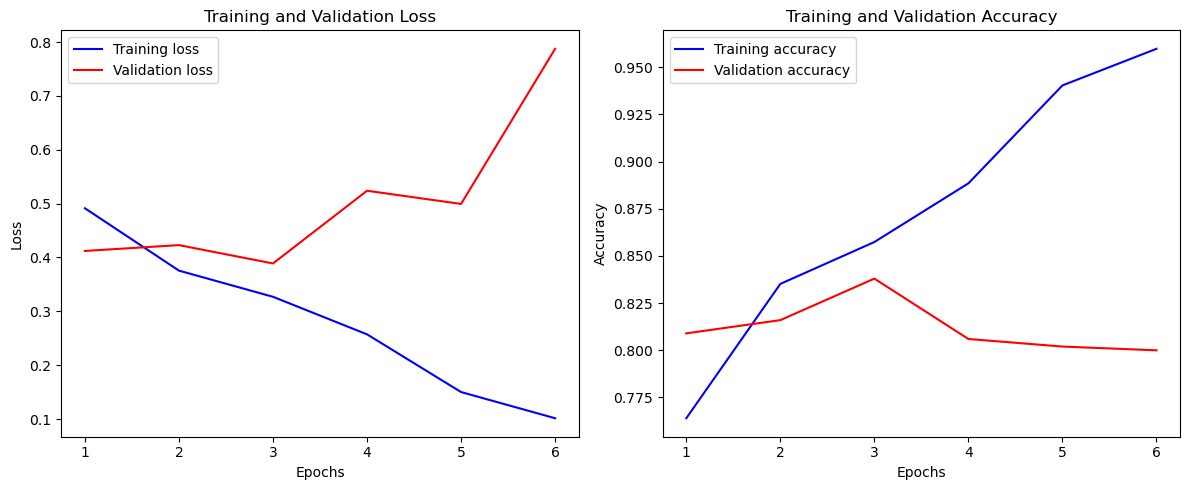

In [92]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Saving Model

In [93]:
model_save_path = 'yelp_classifer_model.pth'

torch.save(model.state_dict(), model_save_path)

### Testing the Model

#### Load Model

In [94]:
finalModel = TransformerSentimentClassifier(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length, embedding_matrix)

finalModel.load_state_dict(torch.load(model_save_path))

finalModel.to(device)

TransformerSentimentClassifier(
  (embedding): Embedding(46883, 200)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=200, out_features=2, bias=True)
)

#### Evaluate

In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# evaluate model
finalModel.eval()

# track loss and accuracy
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

# lists to store true and predicted labels for metric calculation
all_labels = []
all_preds = []

# test
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = finalModel(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
        
        # store true and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# calc average test loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct_predictions / total_predictions

# calculate additional metrics
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Test Loss: 0.6326
Test Accuracy: 82.55%
Precision: 0.81
Recall: 0.75
F1 Score: 0.78
Confusion Matrix:
[[1038  142]
 [ 207  613]]
